# Kinetic description of QED plasma in constant uniform magnetic field

Setup of the paper M Lobet et al 2016 J. Phys.: Conf. Ser. 688 012058 ( https://iopscience.iop.org/article/10.1088/1742-6596/688/1/012058 )

Using the expressions 3.82, 3.91, 4.23 and 4.25 of the PhD thesis by Fabien Niel ( https://link.springer.com/book/10.1007/978-3-030-73547-0 )

Author of notebook: Óscar Amaro


This notebook implments the kinetic equations to evolve in time the distribution functions of electrons, positrons and photons (using RK4 instead of Euler method).
The resolution is controlled by the number of grid points in energy **gmdim** and the numbr of time steps **tdim**.
All three distribution functions are combined into a single column vector **yn**. The $df/dt$ operator is represented in matrix form (with dimensions 3x**gmdim** x 3x**gmdim**). See plots of the matrix.

In [1]:
# numpy
import numpy as np
np.random.seed(19680801)
from numpy.random import default_rng
rng = default_rng()

import pandas as pd

# import functions
from scipy.special import kv, iv, erf
from scipy.integrate import quad
from numpy import log, log10, sin, cos, exp, sqrt, pi

# interpolate
from scipy import interpolate

# physical constants
from scipy.constants import speed_of_light, fine_structure, hbar, elementary_charge, electron_mass

tauC = hbar/(electron_mass*speed_of_light**2) # Compton length
ES = electron_mass**2*speed_of_light**3/elementary_charge/hbar # Schwinger field

# root finding
from scipy.optimize import fsolve
from scipy import optimize

# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import cm

# progress bar
from tqdm.notebook import tqdm
from tqdm import trange
from time import sleep
from tqdm import tqdm

# pickle
import pickle

# warnings
import warnings
warnings.simplefilter('ignore')

def arraycenter(x):
    """
    returns centered array for histograms
    """
    return np.array([(x[i]+x[i+1])/2 for i in range(len(x)-1)])

In [2]:
# main parameters
gmdim = 100 #[] grid dimension
tdim = 4000 # time resolution

# gm
gmmin = 1e-2 #[] minimum energy
gmmax = 3600 #[] maximum energy
dgm = gmmax/gmdim #[] interval in energy
gmlst = np.linspace(gmmin,gmmax,gmdim) #[] energy array
gmlst3 = np.zeros(3*gmdim) #[] energy array triplicated
for i in range(gmdim):
    gmlst3[i] = gmlst[i]
    gmlst3[i+gmdim] = gmlst[i]
    gmlst3[i+2*gmdim] = gmlst[i]

# time
Bfld = 7.48e6; # [T] magnetic field
omega_B = 1/(2.3e-15) #[1/s] reference frequency
tmax = 2.2 #[1/omega_B]
dt = tmax/tdim # time step
tlst = np.linspace(0,tmax,tdim) # time steps array
fdumps = np.zeros((tdim,3*gmdim))

Energydumps_e = np.zeros(tdim)
Energydumps_p = np.zeros(tdim)
Energydumps_g = np.zeros(tdim)
Numberdumps_e = np.zeros(tdim)
Numberdumps_p = np.zeros(tdim)
Chidumps_e = np.zeros(tdim)
Chidumps_p = np.zeros(tdim)
Chidumps_g = np.zeros(tdim)
print("tdim=",tdim)
print("dt=",dt)

def dNdg(gg,gl):
    """
        photon emission nCS (Niel PhD §3.82)
    """
    chi = gl * speed_of_light*Bfld/ES
    chig = gg * speed_of_light*Bfld/ES
    xi = gg/gl
    if gg<=gmmin or gl<=gmmin or xi>=1:
        return 0
    nu = 2*xi/(3*chi*(1-xi))
    Gtil = sqrt(3)/2/pi*xi*( quad(lambda y: kv(5/3,y), nu, np.inf )[0] + 3/2*chig*nu*kv(2/3,nu) )
    res = 1/omega_B * 2/3 * fine_structure/tauC * Gtil/gl/gg
    return res

def dNdl(gg,gl):
    """
        pair production nBW (Niel PhD §3.91)
    """
    chi = gl * speed_of_light*Bfld/ES
    chig = gg * speed_of_light*Bfld/ES
    if gg<=2 or gl<=gmmin or gg<=gl:
        return 0
    xi = chi/chig
    nu = 2/3*chig/chi/(chig-chi)
    TnBW = sqrt(3)/2/pi*xi*( -quad(lambda y: kv(5/3,y), nu, np.inf )[0] + 3/2*chig*nu*kv(2/3,nu) )
    res = 1/omega_B * 2/3 * fine_structure/tauC * TnBW/gl/gg
    return res

# define matrix {e-, e+, g} and submatrices
dfdt_mat = np.zeros((3*gmdim,3*gmdim))
dfdt_mat_11_i = np.zeros((3*gmdim,3*gmdim))
dfdt_mat_11_o = np.zeros((3*gmdim,3*gmdim))
dfdt_mat_13 = np.zeros((3*gmdim,3*gmdim))
dfdt_mat_22_i = np.zeros((3*gmdim,3*gmdim))
dfdt_mat_22_o = np.zeros((3*gmdim,3*gmdim))
dfdt_mat_23 = np.zeros((3*gmdim,3*gmdim))
dfdt_mat_31 = np.zeros((3*gmdim,3*gmdim))
dfdt_mat_32 = np.zeros((3*gmdim,3*gmdim))
dfdt_mat_33 = np.zeros((3*gmdim,3*gmdim))

# electron: outgoing
for i in range(gmdim):
    dfdt_mat_11_o[i,i] = -np.sum( np.array([dNdg(g,gmlst[i]) for g in gmlst[gmlst<gmlst[i]]]) ) * dgm
# electron: ingoing
for i in range(gmdim):
    for j in range(i,gmdim):
        dfdt_mat_11_i[i,j] = dNdg(gmlst[j]-gmlst[i],gmlst[j]) * dgm
# electron: pair production
for i in range(gmdim):
    for j in range(i,gmdim):
        dfdt_mat_13[i,2*gmdim+j] = dNdl(gmlst[j],gmlst[i]) * dgm
        
# positron: outgoing
for i in range(gmdim):
    dfdt_mat_22_o[gmdim+i,gmdim+i] = -np.sum( np.array([dNdg(g,gmlst[i]) for g in gmlst[gmlst<gmlst[i]]]) ) * dgm
# positron: ingoing
for i in range(gmdim):
    for j in range(i,gmdim):
        dfdt_mat_22_i[gmdim+i,gmdim+j] = dNdg(gmlst[j]-gmlst[i],gmlst[j]) * dgm
# positron: pair production
for i in range(gmdim):
    for j in range(i,gmdim):
        dfdt_mat_23[gmdim+i,2*gmdim+j] = dNdl(gmlst[j],gmlst[i]) * dgm

# photon: photon production from leptons
for i in range(gmdim):
    for j in range(i,gmdim):
        # electrons
        dfdt_mat_31[2*gmdim+i,0*gmdim+j] = dNdg(gmlst[i],gmlst[j]) * dgm
        # positrons
        dfdt_mat_32[2*gmdim+i,1*gmdim+j] = dNdg(gmlst[i],gmlst[j]) * dgm
# photon: photon decay
for i in range(gmdim):
    dfdt_mat_33[2*gmdim+i,2*gmdim+i] = -2*np.sum( np.array([dNdl(gmlst[i],g) for g in gmlst[(gmlst<gmlst[i])+(gmlst>=2)]] ) ) * dgm
# add all submatrices
dfdt_mat = dfdt_mat_11_i+dfdt_mat_11_o+dfdt_mat_13 + dfdt_mat_22_i+dfdt_mat_22_o+dfdt_mat_23 + dfdt_mat_31+dfdt_mat_32+dfdt_mat_33
    
def getEnergy(x):
    """1st panel"""
    return np.trapz(x*gmlst,gmlst)

def getNumber(x):
    """2nd panel"""
    return np.trapz(x,gmlst)
    
def getChi(x):
    """3rd panel"""
    return np.trapz(x*gmlst,gmlst)/(np.trapz(x,gmlst)+1e-12) * speed_of_light*Bfld/ES

def dfdt(yn):
    """
    matrix multiplication
    does not depend explicitly on time
    """
    res = np.matmul(dfdt_mat,yn)
    return res

tdim= 4000
dt= 0.00055


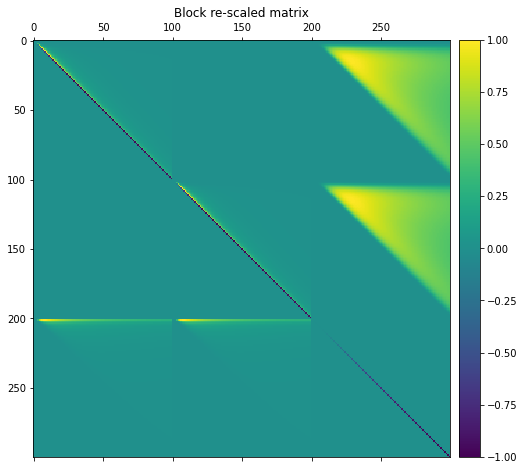

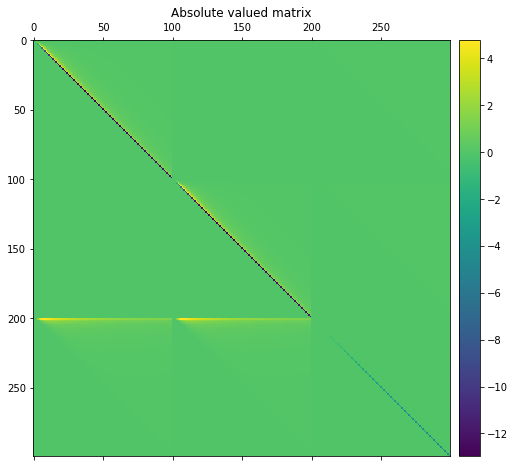

In [3]:
# re-scaled matrix
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
im0=axes.matshow(
    dfdt_mat_11_i/np.max(np.abs(dfdt_mat_11_i))
    +dfdt_mat_11_o/np.max(np.abs(dfdt_mat_11_o))
    +dfdt_mat_13/np.max(np.abs(dfdt_mat_13))
    +dfdt_mat_22_i/np.max(np.abs(dfdt_mat_22_i))
    +dfdt_mat_22_o/np.max(np.abs(dfdt_mat_22_o))
    +dfdt_mat_23/np.max(np.abs(dfdt_mat_23))
    +dfdt_mat_31/np.max(np.abs(dfdt_mat_31))
    +dfdt_mat_32/np.max(np.abs(dfdt_mat_32))
    +dfdt_mat_33/np.max(np.abs(dfdt_mat_33))
)
cbar0 = fig.colorbar(im0, ax=axes, fraction=0.0467, pad=0.02)
plt.title("Block re-scaled matrix")
plt.show()

# absolute matrix
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
im0 = axes.matshow(dfdt_mat)
cbar0 = fig.colorbar(im0, ax=axes, fraction=0.0467, pad=0.02)
plt.title("Absolute valued matrix")
plt.show()

In [4]:
# initial condition
yn = np.zeros(3*gmdim)
gm0 = 3000 #[] initial electron energy
yn[np.abs(gmlst-gm0).argmin()] = 1 # Dirac
#for i in range(gmdim): yn[i] = np.exp( -0.5*(gmlst[i]-gm0)**2/(1*dgm)**2 )
    
# for each time step
fdumps[0,:] = yn
Energydumps_e[0] = getEnergy(yn[:gmdim])
Energydumps_p[0] = getEnergy(yn[gmdim:2*gmdim])
Energydumps_g[0] = getEnergy(yn[2*gmdim:3*gmdim])
Numberdumps_e[0] = getNumber(yn[:gmdim])
Numberdumps_p[0] = getNumber(yn[gmdim:2*gmdim])
Chidumps_e[0] = getChi(yn[:gmdim])
Chidumps_p[0] = getChi(yn[gmdim:2*gmdim])
Chidumps_g[0] = getChi(yn[2*gmdim:3*gmdim])

for t in tqdm(range(1,tdim)):
    # RK4 method https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods
    k1 = dfdt(yn)
    k2 = dfdt(yn+dt*k1/2)
    k3 = dfdt(yn+dt*k2/2)
    k4 = dfdt(yn+dt*k3)
    yn = yn + dt/6 * (k1 + 2*k2 + 2*k3 + k4) # RK4
    yn[yn<=0] = 0
    #yn[np.isnan(yn)] = 0
    
    # save
    Energydumps_e[t] = getEnergy(yn[:gmdim])
    Energydumps_p[t] = getEnergy(yn[gmdim:2*gmdim])
    Energydumps_g[t] = getEnergy(yn[2*gmdim:3*gmdim])
    
    Numberdumps_e[t] = getNumber(yn[:gmdim])
    Numberdumps_p[t] = getNumber(yn[gmdim:2*gmdim])
    
    Chidumps_e[t] = getChi(yn[:gmdim])
    Chidumps_p[t] = getChi(yn[gmdim:2*gmdim])
    Chidumps_g[t] = getChi(yn[2*gmdim:3*gmdim])
    
    fdumps[t,:] = yn

100%|██████████| 3999/3999 [00:02<00:00, 1696.58it/s]


In [5]:
# import data extracted using WebPlotDigitize
Fig1a_Ee = pd.read_csv( "@data/dots_Lobet2016_pde/Fig1a/Ee.txt", header=None)
Fig1a_Eg = pd.read_csv( "@data/dots_Lobet2016_pde/Fig1a/Eg.txt", header=None)
Fig1a_Ep = pd.read_csv( "@data/dots_Lobet2016_pde/Fig1a/Ep.txt", header=None)

Fig1b_ne = pd.read_csv( "@data/dots_Lobet2016_pde/Fig1b/ne.txt", header=None)
Fig1b_np = pd.read_csv( "@data/dots_Lobet2016_pde/Fig1b/np.txt", header=None)

Fig1c_chie = pd.read_csv( "@data/dots_Lobet2016_pde/Fig1c/chie.txt", header=None)
Fig1c_chig = pd.read_csv( "@data/dots_Lobet2016_pde/Fig1c/chig.txt", header=None)
Fig1c_chip = pd.read_csv( "@data/dots_Lobet2016_pde/Fig1c/chip.txt", header=None)

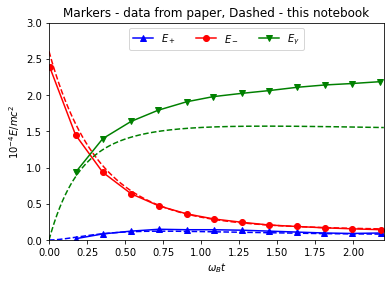

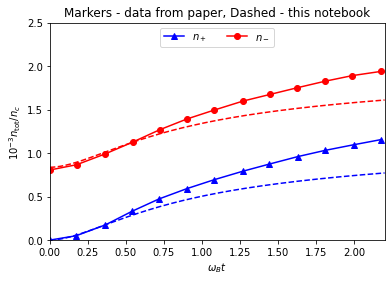

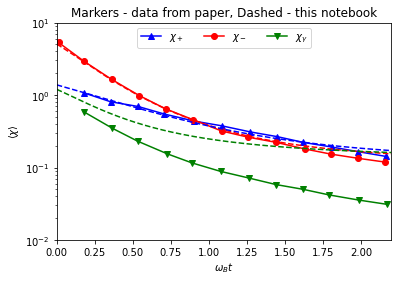

In [14]:
# Fig 1 a
# attention: positrons here are blue
plt.plot(Fig1a_Ep[0], Fig1a_Ep[1], 'b^-', label=r'$E_+$')
plt.plot(Fig1a_Ee[0], Fig1a_Ee[1], 'ro-', label=r'$E_-$')
plt.plot(Fig1a_Eg[0], Fig1a_Eg[1], 'gv-', label=r'$E_\gamma$')
# this notebook
mulC = 2.4e-5
plt.plot(tlst,Energydumps_p*mulC,'--b')
plt.plot(tlst,Energydumps_e*mulC,'--r')
plt.plot(tlst,Energydumps_g*mulC,'--g')
#
plt.title('Markers - data from paper, Dashed - this notebook')
plt.xlabel(r'$\omega_B t$')
plt.ylabel(r'$10^{-4} E/mc^2$')
plt.xlim([0,2.2])
plt.ylim([0,3])
plt.legend(loc='upper center', ncol=3)
plt.show()


# Fig 1 b
plt.plot(Fig1b_np[0], Fig1b_np[1], 'b^-', label=r'$n_+$')
plt.plot(Fig1b_ne[0], Fig1b_ne[1], 'ro-', label=r'$n_-$')
# this notebook
mulC = 2.3e-2
plt.plot(tlst,Numberdumps_e*mulC,'--r')
plt.plot(tlst,Numberdumps_p*mulC,'--b')
#
plt.title('Markers - data from paper, Dashed - this notebook')
plt.xlabel(r'$\omega_B t$')
plt.ylabel(r'$10^{-3} n_\mathrm{tot}/n_c$')
plt.xlim([0,2.2])
plt.ylim([0,2.5])
plt.legend(loc='upper center', ncol=3)
plt.show()

# Fig 1 c
plt.plot(Fig1c_chip[0], Fig1c_chip[1], 'b^-', label=r'$\chi_+$')
plt.plot(Fig1c_chie[0], Fig1c_chie[1], 'ro-', label=r'$\chi_-$')
plt.plot(Fig1c_chig[0], Fig1c_chig[1], 'gv-', label=r'$\chi_\gamma$')
#
plt.plot(tlst[1:],Chidumps_e[1:],'--r')
plt.plot(tlst[1:],Chidumps_p[1:],'--b')
plt.plot(tlst[1:],Chidumps_g[1:],'--g')
#
plt.title('Markers - data from paper, Dashed - this notebook')
plt.xlabel(r'$\omega_B t$')
plt.ylabel(r'$\langle \chi \rangle$')
plt.yscale('log')
plt.xlim([0,2.2])
plt.ylim([1e-2,1e1])
plt.legend(loc='upper center', ncol=3)
plt.show()

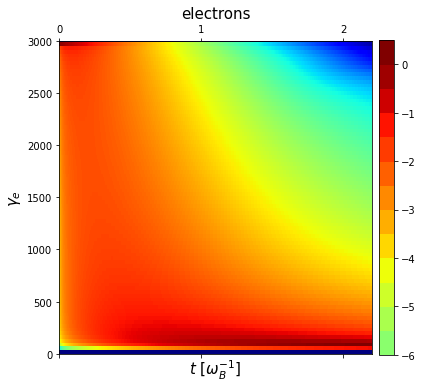

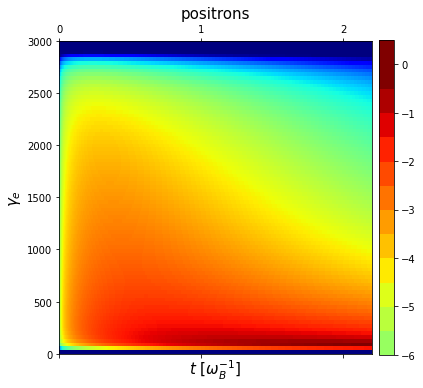

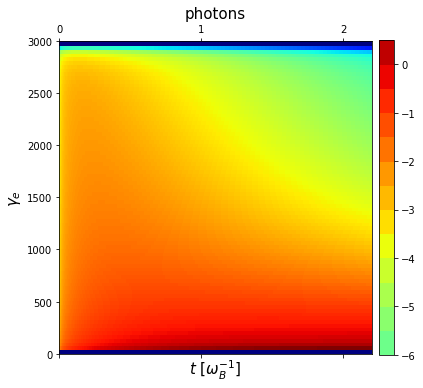

In [15]:
# energy distribution vs time
fntsz = 15
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
X = fdumps[:,:gmdim]
im0=axes.matshow( np.log10(np.rot90(X)+1e-12), extent=[0,tmax,0,gmmax], cmap=cm.jet )
cbar0 = fig.colorbar(im0, ax=axes,fraction=0.047, pad=0.02, boundaries=np.arange(-6,1,0.5))
plt.title("electrons",fontsize=fntsz)
plt.ylim([0,3e3])
plt.xlabel(r'$t~[\omega_B^{-1}]$',fontsize=fntsz)
plt.ylabel(r'$\gamma_e$',fontsize=fntsz)
# aspect
axes.set_aspect(aspect=1/(3e3/tmax))
plt.show()

# energy distribution vs time
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
X = fdumps[:,gmdim:2*gmdim]
im0=axes.matshow( np.log10(np.rot90(X)+1e-12), extent=[0,tmax,0,gmmax], cmap=cm.jet )
cbar0 = fig.colorbar(im0, ax=axes,fraction=0.047, pad=0.02, boundaries=np.arange(-6,1,0.5))
plt.title("positrons",fontsize=fntsz)
plt.ylim([0,3e3])
plt.xlabel(r'$t~[\omega_B^{-1}]$',fontsize=fntsz)
plt.ylabel(r'$\gamma_e$',fontsize=fntsz)
# aspect
axes.set_aspect(aspect=1/(3e3/tmax))
plt.show()

# energy distribution vs time
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
X = fdumps[:,2*gmdim:3*gmdim]
im0=axes.matshow( np.log10(np.rot90(X)+1e-12), extent=[0,tmax,0,gmmax], cmap=cm.jet )
cbar0 = fig.colorbar(im0, ax=axes,fraction=0.047, pad=0.02, boundaries=np.arange(-6,1,0.5))
plt.title("photons",fontsize=fntsz)
plt.ylim([0,3e3])
plt.xlabel(r'$t~[\omega_B^{-1}]$',fontsize=fntsz)
plt.ylabel(r'$\gamma_e$',fontsize=fntsz)
# aspect
axes.set_aspect(aspect=1/(3e3/tmax))
plt.show()

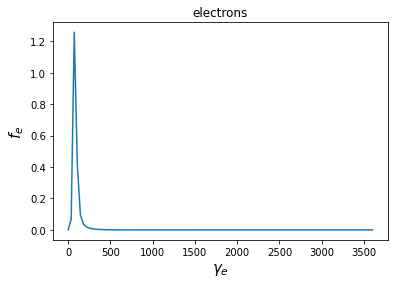

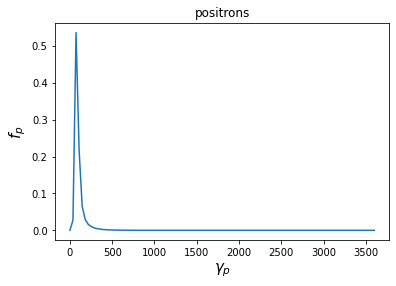

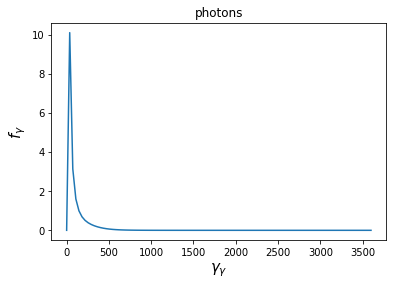

In [17]:
# plot whole distribution function
"""
indx = 10
plt.plot(fdumps[indx,:])
plt.show()
"""

# plot individual distribution functions
indx = -1
fntsz = 15
plt.plot(gmlst3[:gmdim],fdumps[indx,:gmdim])
plt.xlabel(r'$\gamma_e$',fontsize=fntsz)
plt.ylabel(r'$f_e$',fontsize=fntsz)
plt.title("electrons")
plt.show()
plt.plot(gmlst3[gmdim:2*gmdim],fdumps[indx,gmdim:2*gmdim])
plt.xlabel(r'$\gamma_p$',fontsize=fntsz)
plt.ylabel(r'$f_p$',fontsize=fntsz)
plt.title("positrons")
plt.show()
plt.plot(gmlst3[2*gmdim:3*gmdim],fdumps[indx,2*gmdim:3*gmdim])
plt.xlabel(r'$\gamma_\gamma$',fontsize=fntsz)
plt.ylabel(r'$f_\gamma$',fontsize=fntsz)
plt.title("photons")
plt.show()